<a href="https://colab.research.google.com/github/ITEX-sites/Garibaldi/blob/cnorton27-editbranch/Caret_RF_Supervised_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing dependencies

In [12]:
%%shell
yes | add-apt-repository ppa:ubuntugis/ppa
apt-get update
apt-get install gdal-bin libgdal-dev
C_INCLUDE_PATH=/usr/include/gdal CPLUS_INCLUDE_PATH=/usr/include/gdal python -m pip install GDAL=="$(gdal-config --version)"



PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu/ jammy main'
Description:
Official stable UbuntuGIS packages.


More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ppa.gpg with fingerprint 6B827C12C2D425E227EDCA75089EBE08314DF160
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates

In [13]:
!apt-get install -y python3-gdal

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-gdal is already the newest version (3.6.4+dfsg-1~jammy0).
The following packages were automatically installed and are no longer required:
  libcharls-dev libgeos3.10.2
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 76 not upgraded.


In [14]:
pip install rasterio scikit-learn-intelex


In [15]:
from sklearnex import patch_sklearn
patch_sklearn()
import rasterio as rio
import numpy as np
import geopandas as pd
from sklearn.model_selection import train_test_split
import fiona
from rasterio.features import geometry_mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from rasterio.plot import show
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from osgeo import ogr, gdal
from glob import glob
import rasterio.warp
from rasterio.enums import Resampling
import subprocess

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preparing the raster data for model input

In [32]:
# input files
satellite2 = '/content/drive/MyDrive/PIXELS_python/Data/sat_clip.tif'
#points = '/content/drive/MyDrive/PIXELS_python/Data/training_points/training_points.shp'
points = '/content/drive/MyDrive/PIXELS_python/training_points_sat_pilot/training_points_satpoly.shp'
temp_point_loc = '/content/drive/MyDrive/PIXELS_python/Data/empty_shp/empty.shp'
dem_path = '/content/drive/MyDrive/PIXELS_python/Data/clipped_dem.tif'

In [ ]:
#Get CRS for both DEM and Sat

sat = rasterio.open(satellite2)
DEM = rasterio.open(dem_path)
DEM_src = DEM.read(1)
band1 = sat.read(1)
band2 = sat.read(2)

plt.imshow(band2, cmap = "BrBG")
plt.title("Satellite Image")
plt.show()

print("Satellite Coordinate Reference System")
sat_crs = sat.crs
print(sat_crs)

print("DEM Coordinate Reference System")
dem_crs = DEM.crs
print(dem_crs)

plt.imshow(DEM_src, cmap = "BrBG")
plt.title("DEM")
plt.show()

In [ ]:
#reproject layers to match CRS of satellite imagery (or other crs)

def reproject_raster(in_path, out_path, target_crs):
    with rio.open(in_path) as src:
        transform, width, height = rio.warp.calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                rio.warp.reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )

# assign target crs to variable, define output directory for reprojected layers
target_crs = 'EPSG:32610'
output_dem = "/content/drive/MyDrive/PIXELS_python/Data/reprojected_DEM.tif"

# Reproject the slope, tpi, and any other rasters used as model input
reproject_raster(dem_path, output_dem, target_crs)

#reassign variables
dem_path = output_dem

DEM = rasterio.open(dem_path)
print("DEM Coordinate Reference System")
dem_crs = DEM.crs
print(dem_crs)

In [ ]:
#Creating Slope and Aspect and TPI Rasters from the DEM

slope_output_path = '/content/drive/MyDrive/PIXELS_python/Data/slope.tif'
aspect_output_path = '/content/drive/MyDrive/PIXELS_python/Data/aspect.tif'

# Open the DEM raster
with rasterio.open(dem_path) as dem_src:
    # Read the DEM data as a numpy array
    dem = dem_src.read(1)

    # Calculate slope using numpy.gradient
    slope_x, slope_y = np.gradient(dem_src.read(1), dem_src.res[0], dem_src.res[1])
    slope = np.arctan(np.sqrt(slope_x**2 + slope_y**2))

    # Calculate aspect using numpy.arctan2
    aspect = np.arctan2(-slope_y, slope_x)

     # Save the slope as a new raster
    with rasterio.open(
        slope_output_path,
        'w',
        driver='GTiff',
        width=dem_src.width,
        height=dem_src.height,
        count=1,
        dtype=slope.dtype,
        crs=dem_src.crs,
        transform=dem_src.transform,
    ) as slope_dst:
        slope_dst.write(slope, 1)

     # Save the aspect as a new raster
    with rasterio.open(
        aspect_output_path,
        'w',
        driver='GTiff',
        width=dem_src.width,
        height=dem_src.height,
        count=1,
        dtype=aspect.dtype,
        crs=dem_src.crs,
        transform=dem_src.transform,
    ) as aspect_dst:
        aspect_dst.write(aspect, 1)

# Convert aspect values to degrees
aspect = np.degrees(aspect)

#calculating TPI
TPI_output_path = '/content/drive/MyDrive/PIXELS_python/Data/TPI.tif'
gdal_TPI_cmd = ['gdaldem', 'TPI', dem_path, TPI_output_path]

subprocess.run(gdal_TPI_cmd)

slope_path = slope_output_path
aspect_path = aspect_output_path
tpi_path = TPI_output_path

#Plotting the rasters
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(dem, cmap='terrain', extent=rasterio.plot.plotting_extent(dem_src))
plt.title('DEM')

plt.subplot(1, 4, 2)
plt.imshow(slope, cmap='viridis', extent=rasterio.plot.plotting_extent(dem_src))
plt.title('Slope')

plt.subplot(1, 4, 3)
plt.imshow(aspect, cmap='twilight', extent=rasterio.plot.plotting_extent(dem_src))
plt.title('Aspect')

plt.show()



# Normalizing Rasters

In [ ]:
#setting decimal precision of raster arrays
np.set_printoptions(precision=3)
np.get_printoptions()

#variables to change formatting of subplots
row_num = 3
colum_num = 4

#assigning each band to a variable and normalizing raster layer using standard normalization
with rio.open(satellite2) as sat:
  sat_transform = sat.transform
  sat_crs = sat.crs
  band1 = sat.read(1)
  band1_mean_pixel = np.mean(band1)
  band1_normalized = band1 / band1_mean_pixel
  print(band1_mean_pixel)

  band2 = sat.read(2)
  band2_mean_pixel = np.mean(band2)
  band2_minus_mean = band2 - band2_mean_pixel
  band2_std = np.std(band2)
  band2_normalized = band2_minus_mean / band2_std

  band3 = sat.read(3)
  band3_mean_pixel = np.mean(band3)
  band3_minus_mean = band3 - band3_mean_pixel
  band3_std = np.std(band3)
  band3_normalized = band3_minus_mean / band3_std

  band4 = sat.read(4)
  band4_mean_pixel = np.mean(band4)
  band4_minus_mean = band4 - band4_mean_pixel
  band4_std = np.std(band4)
  band4_normalized = band4_minus_mean / band4_std

  band5 = sat.read(5)
  band5_mean_pixel = np.mean(band5)
  band5_minus_mean = band5 - band5_mean_pixel
  band5_std = np.std(band5)
  band5_normalized = band5_minus_mean / band5_std

  band6 = sat.read(6)
  band6_mean_pixel = np.mean(band6)
  band6_minus_mean = band6 - band6_mean_pixel
  band6_std = np.std(band6)
  band6_normalized = band6_minus_mean / band6_std

  band7 = sat.read(7)
  band7_mean_pixel = np.mean(band7)
  band7_minus_mean = band7 - band7_mean_pixel
  band7_std = np.std(band7)
  band7_normalized = band7_minus_mean / band7_std

  band8 = sat.read(8)
  band8_mean_pixel = np.mean(band8)
  band8_minus_mean = band8 - band8_mean_pixel
  band8_std = np.std(band8)
  band8_normalized = band8_minus_mean / band8_std

  fig, ax = plt.subplots(row_num, colum_num, figsize=(14,16))
  plt.subplot(row_num, colum_num, 1)
  plt.imshow(band1_normalized, cmap='pink')
  plt.title('Band1 Normalized')
  plt.subplot(row_num, colum_num, 2)
  plt.imshow(band2_normalized, cmap='pink')
  plt.title('Band2 Normalized')
  plt.subplot(row_num, colum_num, 3)
  plt.imshow(band3_normalized, cmap='pink')
  plt.title('Band3 Normalized')
  plt.subplot(row_num, colum_num, 4)
  plt.imshow(band4_normalized, cmap='pink')
  plt.title('Band4 Normalized')
  plt.subplot(row_num, colum_num, 5)
  plt.imshow(band5_normalized, cmap='pink')
  plt.title('Band5 Normalized')
  plt.subplot(row_num, colum_num, 6)
  plt.imshow(band6_normalized, cmap='pink')
  plt.title('Band6 Normalized')
  plt.subplot(row_num, colum_num, 7)
  plt.imshow(band7_normalized, cmap='pink')
  plt.title('Band7 Normalized')
  plt.subplot(row_num, colum_num, 8)
  plt.imshow(band8_normalized, cmap='pink')
  plt.title('Band8 Normalized')

with rio.open(dem_path) as dem:
  dem_transform = sat.transform
  dem_crs = sat.crs
  DEM = dem.read(1)
  dem_mean_pixel = np.mean(DEM)
  dem_minus_mean = DEM - dem_mean_pixel
  dem_std = np.std(DEM)
  dem_normalized = dem_minus_mean / dem_std
  plt.subplot(row_num, colum_num, 9)
  plt.imshow(DEM, cmap='BrBG')
  plt.title("DEM Normalized")

with rio.open(aspect_path) as asp:
  aspect = asp.read(1)
  aspect_mean_pixel = np.mean(aspect)
  aspect_minus_mean = aspect - aspect_mean_pixel
  aspect_std = np.std(aspect)
  aspect_normalized = aspect_minus_mean / aspect_std
  plt.subplot(row_num, colum_num, 10)
  plt.imshow(aspect, cmap='BrBG')
  plt.title("Aspect Normalized")

with rio.open(tpi_path) as tpi:
  TPI = tpi.read(1)
  tpi_mean_pixel = np.mean(TPI)
  tpi_minus_mean = TPI - tpi_mean_pixel
  tpi_std = np.std(TPI)
  tpi_normalized = tpi_minus_mean / tpi_std
  plt.subplot(row_num, colum_num, 11)
  plt.imshow(TPI, cmap='BrBG')

with rio.open(slope_path) as slp:
  slope = slp.read(1)
  slope_mean_pixel = np.mean(slope)
  slope_minus_mean = slope - slope_mean_pixel
  slope_std = np.std(slope)
  slope_normalized = slope_minus_mean / slope_std
  plt.subplot(row_num, colum_num, 12)
  plt.imshow(slope, cmap='BrBG')
  plt.title('Slope Normalized')



In [ ]:
#saving normalized rasters
aspect_norm_path = '/content/drive/MyDrive/PIXELS_python/Data/aspect_norm.tif'
dem_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/dem_norm.tif'
slope_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/slope_norm.tif'
tpi_norm_path = '/content/drive/MyDrive/PIXELS_python/Data/tpi_norm.tif'
band1_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band1_norm.tif'
band2_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band2_norm.tif'
band3_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band3_norm.tif'
band4_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band4_norm.tif'
band5_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band5_norm.tif'
band6_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band6_norm.tif'
band7_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band7_norm.tif'
band8_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band8_norm.tif'

sat_height, sat_width = band1.shape
#dem_height, dem_width = dem.shape

metadata_sat = {
    'driver': 'GTiff',
    'count': 1,
    'dtype': 'float32',
    'width': sat_width,
    'height': sat_height,
    'crs': sat_crs,
    'transform': sat_transform
}

metadata_dem = {
    'driver': 'GTiff',
    'count': 1,
    'dtype': 'float32',
    'width': sat_width,
    'height': sat_height,
    'crs': dem_crs,
    'transform': dem_transform
}

def saving_sat(out_path, band):
  with rasterio.open(out_path, 'w', **metadata_sat) as rast:
    rast.write(band, 1)

def saving_topo(out_path, band):
  with rasterio.open(out_path, 'w', **metadata_dem) as rast:
    rast.write(band, 1)

saving_sat(band1_norm_path, band1_normalized)
saving_sat(band2_norm_path, band2_normalized)
saving_sat(band3_norm_path, band3_normalized)
saving_sat(band4_norm_path, band4_normalized)
saving_sat(band5_norm_path, band5_normalized)
saving_sat(band6_norm_path, band6_normalized)
saving_sat(band7_norm_path, band7_normalized)
saving_sat(band8_norm_path, band8_normalized)
saving_topo(dem_norm_path, dem_normalized)
saving_topo(tpi_norm_path, tpi_normalized)
saving_topo(aspect_norm_path, aspect_normalized)
saving_topo(slope_norm_path, slope_normalized)

In [ ]:
#stacking rasters
input_rasters = [band1_norm_path, band2_norm_path, band3_norm_path, band4_norm_path, band5_norm_path, band6_norm_path,
                 band7_norm_path, band8_norm_path, dem_norm_path, slope_norm_path, aspect_norm_path, tpi_norm_path]

output_stack = "/content/drive/MyDrive/PIXELS_python/Data/virtual_raster_normalized.tif"
gdal_cmd_vrt = ['gdalbuildvrt', '-separate', '-resolution', 'highest', '-r', 'near', output_stack,] + input_rasters

subprocess.run(gdal_cmd_vrt)

stacked = output_stack

#saving each stacked band as a variable to inspect data
with rio.open(stacked) as stk:
  stk1 = stk.read(1)
  stk2 = stk.read(2)
  stk3 = stk.read(3)
  stk4 = stk.read(4)
  stk5 = stk.read(5)
  stk6 = stk.read(6)
  stk7 = stk.read(7)
  stk8 = stk.read(8)
  stk_dem = stk.read(9)
  stk_slope = stk.read(10)
  stk_aspect = stk.read(11)
  stk_tpi = stk.read(12)
  num_bands = stk.count

In [ ]:
#visualize layers in the stack
plt.imshow(stk_dem, cmap="pink")
print(stk_dem)

#Training The Model

In [33]:
stacked = "/content/drive/MyDrive/PIXELS_python/Data/virtual_raster_normalized.tif"

import time
import collections

landclass_array = collections.deque([])
stacked_deque_array = collections.deque([])

with rio.open(stacked) as stack_src:
  with fiona.open(points) as shp:
      print('Number of coords:', len(shp))
      for index,feature in enumerate(shp):
          siteID = feature['properties']['num_class']
          coords = feature['geometry']['coordinates']
          value = [v for v in stack_src.sample([coords])]
          landclass_array.append(np.array([siteID]))
          stacked_deque_array.append(np.array(np.squeeze(value)))

         # if index%1000 == 0:
          #  print('Index:', index)

landclass_np_array = np.asarray(landclass_array)
stacked_np_array = np.asarray(stacked_deque_array)

print(landclass_np_array.shape)
print(stacked_np_array.shape)

print(landclass_np_array)
print(stacked_np_array)

Number of coords: 91894
(91894, 1)
(91894, 12)
[[1]
 [1]
 [1]
 ...
 [6]
 [6]
 [6]]
[[ 0.05788583 -0.62614894 -0.5477507  ... -1.2711684   1.5067273
   0.12767518]
 [ 0.0888248  -0.60935575 -0.52771056 ... -1.3370304   0.9627964
   0.1272774 ]
 [ 0.11676968 -0.58891183 -0.49592274 ... -1.3370304   0.9627964
   0.1272774 ]
 ...
 [ 0.01397244 -0.7269082  -0.6382768  ... -0.45486563 -1.3699982
   0.12847073]
 [ 0.01796457 -0.7247178  -0.6362037  ... -0.45486563 -1.3699982
   0.12847073]
 [ 0.01197638 -0.73493975 -0.64242303 ... -0.44926512 -1.5340289
   0.12807296]]


In [34]:
X = stacked_np_array
Y = landclass_np_array[:,0]
Y = Y.astype('int')

print(X)
print(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

[[ 0.05788583 -0.62614894 -0.5477507  ... -1.2711684   1.5067273
   0.12767518]
 [ 0.0888248  -0.60935575 -0.52771056 ... -1.3370304   0.9627964
   0.1272774 ]
 [ 0.11676968 -0.58891183 -0.49592274 ... -1.3370304   0.9627964
   0.1272774 ]
 ...
 [ 0.01397244 -0.7269082  -0.6382768  ... -0.45486563 -1.3699982
   0.12847073]
 [ 0.01796457 -0.7247178  -0.6362037  ... -0.45486563 -1.3699982
   0.12847073]
 [ 0.01197638 -0.73493975 -0.64242303 ... -0.44926512 -1.5340289
   0.12807296]]
[1 1 1 ... 6 6 6]
X_train Shape: (64325, 12)
X_test Shape: (27569, 12)
y_train Shape: (64325,)
y_test Shape:(27569,)


# **Fitting the model**

In [20]:
pip install pycaret scikit-learn-intelex

In [12]:
pip import pycaret

ERROR: unknown command "import"


In [13]:
X_1 = [inner_array[0] for inner_array in X]
X_2 = [inner_array[1] for inner_array in X]
X_3 = [inner_array[2] for inner_array in X]
X_4 = [inner_array[3] for inner_array in X]
X_5 = [inner_array[4] for inner_array in X]
X_6 = [inner_array[5] for inner_array in X]
X_7 = [inner_array[6] for inner_array in X]
X_8 = [inner_array[7] for inner_array in X]
X_9 = [inner_array[8] for inner_array in X]
X_10 = [inner_array[9] for inner_array in X]
X_11 = [inner_array[10] for inner_array in X]
X_12 = [inner_array[11] for inner_array in X]

#dataset = pd.DataFrame({'classes': Yi, 'raster': list(Xi)}, columns=['raster val', 'label'])
df = pd.DataFrame({'Class': Y, 'Band1': X_1, 'Band2': X_2, 'Band3': X_3, 'Band4': X_4, 'Band5': X_5, 'Band6': X_6, 'Band7': X_7, 'Band8': X_8, 'DEM': X_9, 'Slope': X_10, 'Aspect': X_11, 'TPI': X_12})

# Displaying the DataFrame
print(df)

        Class     Band1     Band2     Band3     Band4     Band5     Band6  \
0           9  0.057886 -0.626149 -0.547751 -0.471234 -0.427651 -0.426901   
1           9  0.088825 -0.609356 -0.527711 -0.481469 -0.425092 -0.418159   
2           9  0.116770 -0.588912 -0.495923 -0.471234 -0.410384 -0.393276   
3           9  0.134734 -0.561897 -0.471045 -0.418693 -0.382246 -0.383189   
4           9  0.140722 -0.552405 -0.466208 -0.412552 -0.358585 -0.371757   
...       ...       ...       ...       ...       ...       ...       ...   
110407      2  0.436140 -0.328252 -0.428201 -0.544245 -0.707751 -0.747680   
110408      2  0.420171 -0.332633 -0.431656 -0.547657 -0.698159 -0.748353   
110409      2  0.433146 -0.329712 -0.437184 -0.541516 -0.710949 -0.739610   
110410      2  0.397217 -0.329712 -0.426819 -0.546292 -0.711588 -0.744318   
110411      2  0.392226 -0.335553 -0.424746 -0.542198 -0.707751 -0.744990   

           Band7     Band8       DEM     Slope    Aspect       TPI  
0     

In [15]:
from pycaret.classification import *
exp_name = setup(data = df,  target = 'Class')
rf = create_model('rf')
pred_holdout = predict_model(rf)
pred_unseen = predict_model(rf, data = df)

,Description,Value
0,Session id,8328
1,Target,Class
2,Target type,Multiclass
3,Target mapping,"0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12"
4,Original data shape,"(110412, 13)"
5,Transformed data shape,"(110412, 13)"
6,Transformed train set shape,"(77288, 13)"
7,Transformed test set shape,"(33124, 13)"
8,Numeric features,12
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9992,1.0000,0.9992,0.9992,0.9992,0.9989,0.9989
1,0.9995,1.0000,0.9995,0.9995,0.9995,0.9993,0.9993
2,0.9990,1.0000,0.9990,0.9990,0.9990,0.9986,0.9986
3,0.9992,1.0000,0.9992,0.9992,0.9992,0.9989,0.9989
4,0.9991,1.0000,0.9991,0.9991,0.9991,0.9987,0.9987
5,0.9991,1.0000,0.9991,0.9991,0.9991,0.9987,0.9987
6,0.9992,1.0000,0.9992,0.9992,0.9992,0.9989,0.9989
7,0.9990,1.0000,0.9990,0.9990,0.9990,0.9986,0.9986
8,0.9992,1.0000,0.9992,0.9992,0.9992,0.9989,0.9989


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9993,1.0000,0.9993,0.9993,0.9993,0.9990,0.9990


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9998,1.0000,0.9998,0.9998,0.9998,0.9997,0.9997


In [16]:
best = compare_models()
#32 mins, 1934sec

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9995,1.0000,0.9995,0.9995,0.9995,0.9992,0.9992,3.1120
xgboost,Extreme Gradient Boosting,0.9993,1.0000,0.9993,0.9993,0.9993,0.9991,0.9991,7.9670
rf,Random Forest Classifier,0.9992,1.0000,0.9992,0.9993,0.9992,0.9989,0.9989,7.5180
knn,K Neighbors Classifier,0.9984,0.9999,0.9984,0.9984,0.9984,0.9978,0.9978,3.0190
gbc,Gradient Boosting Classifier,0.9984,0.9999,0.9984,0.9985,0.9984,0.9978,0.9978,232.7980
dt,Decision Tree Classifier,0.9982,0.9991,0.9982,0.9982,0.9982,0.9975,0.9975,0.3100
qda,Quadratic Discriminant Analysis,0.9762,0.9994,0.9762,0.9790,0.9770,0.9668,0.9669,0.1630
lr,Logistic Regression,0.9567,0.9984,0.9567,0.9557,0.9528,0.9393,0.9397,16.8490
lda,Linear Discriminant Analysis,0.9362,0.9952,0.9362,0.9392,0.9363,0.9109,0.9111,0.3800
svm,SVM - Linear Kernel,0.9336,0.0000,0.9336,0.9287,0.9161,0.9065,0.9084,1.2720


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [21]:
from sklearn.model_selection import GridSearchCV
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the model and GridSearchCV
model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Access results
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate on the test set
test_accuracy = best_model.score(X_test, y_test)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", test_accuracy)



Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Test Accuracy: 0.9994565873686753


In [29]:
#RF classifier
clf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 1, min_samples_split = 5, max_depth = None, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# metrics are used to find accuracy or error
from sklearn import metrics
print()

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))



ACCURACY OF THE MODEL:  0.9993660185967879


Confusion Matrix RF: 
 [[ 1062     0     0     0     0     0     0     0     5     0     0     0
      0]
 [    0 15474     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0    63     1     0     0     0     0     1     0     0     0
      0]
 [    0     0     0   161     4     0     0     0     0     0     0     0
      0]
 [    0     0     0     1   256     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0   440     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0  3098     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0   280     0     0     1     0
      0]
 [    0     0     0     2     0     0     0     0  4034     0     1     0
      0]
 [    0     0     0     1     1     0     0     0     0   181     0     0
      0]
 [    0     0     0     0     0     0     0     0     3     0   511     0
      0]
 [    0     0     0     0     0     0     0     0     0     0   

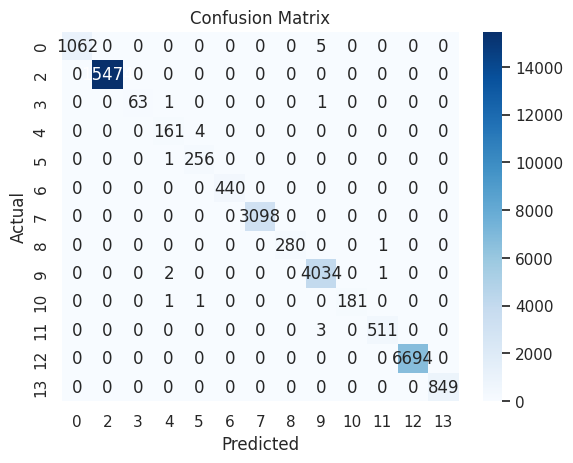

In [31]:
#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix RF: \n',cm)

lulc_name = ['1', '2', '3', '4', '5', '4', '6', '7', '8', '9', '10', '11', '12', '13'],

labels = np.unique(y_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Exporting the model as a raster

In [ ]:
%%time
cName = 'random_forest_caret_ciara'
exp_name = f'/content/drive/MyDrive/PIXELS_python/Data/model_exports/rf/{cName}.tif'


img = rio.open(stacked)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, num_bands)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

In [ ]:
#pred_full = clf.predict(img_n)
pred_full = best.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)


out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1, # output band number
                                          dtype='uint16', #output data type
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()